In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import warnings


from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

from xgboost import XGBRegressor

from sklearn import set_config
set_config(display = 'diagram')
# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [2]:
users_df = pd.read_csv('../raw_data/olist/olist_customers_dataset.csv')
# centers_df = pd.read_csv('../raw_data/distribution_centers.csv')
# events_df = pd.read_csv('../raw_data/events.csv')
# inventory_items_df = pd.read_csv('../raw_data/inventory_items.csv')
order_items_df = pd.read_csv('../raw_data/olist/olist_order_items_dataset.csv')
orders_df = pd.read_csv('../raw_data/olist/olist_orders_dataset.csv')
products_df = pd.read_csv('../raw_data/olist/olist_products_dataset.csv')

## Data Exploration

In [8]:
orders_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [9]:
order_items_df.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

## Return Datetime Format of order dataset. 
## And calculate each order's revenue

In [ ]:
def data_cleaning(order_items_df, orders_df):
    '''
    This function takes the order_items and the orders tables, aggregates the order_items table,
    merges the tables, cleans the datatypes and returns the cleaned dataframe
    '''

    # Agreegate the sale_price by order_id and merge the orders table
    order_sales = order_items_df[['order_id','sale_price']].groupby(by='order_id').sum('sale_price').reset_index()
    cleaned_order_sales = orders_df.merge(order_sales, on='order_id', how='left')

    # Convert the created_at column from 'object' to datetime64
    cleaned_order_sales['created_at'] = pd.to_datetime(cleaned_order_sales['created_at'],
                                                       format='mixed').dt.tz_localize(None)
    cleaned_order_sales['returned_at'] = pd.to_datetime(cleaned_order_sales['returned_at'],
                                                       format='mixed').dt.tz_localize(None)
    cleaned_order_sales['shipped_at'] = pd.to_datetime(cleaned_order_sales['shipped_at'],
                                                       format='mixed').dt.tz_localize(None)
    cleaned_order_sales['delivered_at'] = pd.to_datetime(cleaned_order_sales['delivered_at'],
                                                       format='mixed').dt.tz_localize(None)


    return cleaned_order_sales

In [ ]:
test_check = data_cleaning(order_items_df, orders_df)

In [ ]:
test_check[test_check.user_id == 1]

## Order level information 
### Calculates RFM

In [31]:
def cast_dt(orders_df, order_items_df):
    order_columns = [
            'order_purchase_timestamp'
            ,'order_approved_at'
            ,'order_delivered_carrier_date'
            ,'order_delivered_customer_date'
            ,'order_estimated_delivery_date' 
            ]

    for column in order_columns:
        orders_df[column] = pd.to_datetime(orders_df[column])

    order_items_df['shipping_limit_date'] = pd.to_datetime(order_items_df['shipping_limit_date'])

    return orders_df, order_items_df

In [29]:
def calc_revenue_per_order(orders_df, order_items_df):
    revenue = order_items_df.groupby(by='order_id')['price'].sum().reset_index(name='revenue')
    result = orders_df.merge(revenue, on='order_id', how='left')

    return result

In [38]:
def order_features(orders_df, order_items_df, split_date):
    '''
    Calculates features required for XBG
    inputs order_df, order_items_df, products_df
    Assumes revenue per order is already calculated in sale_price column,
    all the datetime fields and split_date should be in datetime format
    '''
    orders_df, order_items_df = order_cast_dt(orders_df, order_items_df)
    orders_df = calc_revenue_per_order(orders_df, order_items_df)

    # Days calculation
    orders_df['days_to_split_date'] = (split_date - orders_df['order_purchase_timestamp']).dt.days
    orders_df['days_delivery'] = (orders_df['order_delivered_customer_date'] - orders_df['order_purchase_timestamp']).dt.days

    # Filter data only for last 2 years
    # orders_df = orders_df[(orders_df.days_to_split_date >= 0) & (orders_df.days_to_split_date < days_history)]
    orders_df = orders_df[orders_df.order_purchase_timestamp < split_date] # changed to take all historical data

    # Base dataset : user level
    base = orders_df.groupby('customer_id')['order_id'].count().reset_index(name='orders_total')
    rev_total = orders_df.groupby('customer_id')['revenue'].sum().reset_index(name='revenue_total')
    base = base.merge(rev_total,on='customer_id',how='left')

    # Calculate first purchase, latest purchase
    first_purchase = orders_df.groupby('customer_id')['order_purchase_timestamp'].min().reset_index(name='min_created_at')
    base = base.merge(first_purchase, on='customer_id')
    latest_purchase = orders_df.groupby('customer_id')['order_purchase_timestamp'].max().reset_index(name='max_created_at')
    base = base.merge(latest_purchase, on='customer_id')

    # Days from first/last order (Recency, customer T)
    base['days_from_first_order'] =  (split_date - base['min_created_at']).dt.days # This is customer T
    base['days_from_last_order'] =  (split_date - base['max_created_at']).dt.days # This is recency
    base['order_frequency'] =  base['days_from_first_order']/base['orders_total'] # how many orders did he/she make since first purchase
    

    min_date = orders_df['order_purchase_timestamp'].min()
    time_total = (split_date - min_date).days
    time_section = int(time_total/5)
    
    # Count of orders per period
    df_5 = orders_df[orders_df.days_to_split_date < time_section]
    df_4 = orders_df[(orders_df.days_to_split_date >= time_section) & (orders_df.days_to_split_date < time_section*2)]
    df_3 = orders_df[(orders_df.days_to_split_date >= time_section*2) & (orders_df.days_to_split_date < time_section*3)]
    df_2 = orders_df[(orders_df.days_to_split_date >= time_section*3) & (orders_df.days_to_split_date < time_section*4)]
    df_1 = orders_df[(orders_df.days_to_split_date >= time_section*4) & (orders_df.days_to_split_date < time_total)]

    # orders per different timeframe
    f_5 = df_5[['customer_id','order_id']].groupby(by='customer_id').count().fillna(0).rename(columns={'order_id': 'orders_5'})
    f_4 = df_4[['customer_id','order_id']].groupby(by='customer_id').count().fillna(0).rename(columns={'order_id': 'orders_4'})
    f_3 = df_3[['customer_id','order_id']].groupby(by='customer_id').count().fillna(0).rename(columns={'order_id': 'orders_3'})
    f_2 = df_2[['customer_id','order_id']].groupby(by='customer_id').count().fillna(0).rename(columns={'order_id': 'orders_2'})
    f_1 = df_1[['customer_id','order_id']].groupby(by='customer_id').count().fillna(0).rename(columns={'order_id': 'orders_1'})

    # Frequency Joined to base dataset
    base = base.merge(f_5,on='customer_id',how='left')
    base = base.merge(f_4,on='customer_id',how='left')
    base = base.merge(f_3,on='customer_id',how='left')
    base = base.merge(f_2,on='customer_id',how='left')
    base = base.merge(f_1,on='customer_id',how='left')

    # orders per different timeframe
    m_5 = df_5[['customer_id','revenue']].groupby(by='customer_id').sum().fillna(0).rename(columns={'revenue': 'revenue_5'})
    m_4 = df_4[['customer_id','revenue']].groupby(by='customer_id').sum().fillna(0).rename(columns={'revenue': 'revenue_4'})
    m_3 = df_3[['customer_id','revenue']].groupby(by='customer_id').sum().fillna(0).rename(columns={'revenue': 'revenue_3'})
    m_2 = df_2[['customer_id','revenue']].groupby(by='customer_id').sum().fillna(0).rename(columns={'revenue': 'revenue_2'})
    m_1 = df_1[['customer_id','revenue']].groupby(by='customer_id').sum().fillna(0).rename(columns={'revenue': 'revenue_1'})

    # Monetary Joined to base dataset
    base = base.merge(m_5,on='customer_id',how='left')
    base = base.merge(m_4,on='customer_id',how='left')
    base = base.merge(m_3,on='customer_id',how='left')
    base = base.merge(m_2,on='customer_id',how='left')
    base = base.merge(m_1,on='customer_id',how='left')

    # ABV calculation
    base['abv'] = base['revenue_total']/base['orders_total']

    # Other calcs (delivery, num_items)
    avg_delivery_days = orders_df[['customer_id','days_delivery']].groupby('customer_id').mean().rename(columns={'days_delivery': 'avg_delivery_days'})
    base = base.merge(avg_delivery_days, on='customer_id')

    # Fill NA with 0 for selected columns
    selected_columns = [
        'orders_total',
        'revenue_total',
        'orders_5',
        'orders_4',
        'orders_3',
        'orders_2',
        'orders_1',
        'revenue_1',
        'revenue_2',
        'revenue_3',
        'revenue_4',
        'revenue_5']

    base[selected_columns] = base[selected_columns].fillna(0)

    return base

In [45]:
temp_date = dt.datetime(2018,4,1)
result = order_features(orders_df, order_items_df, temp_date)
result.head(50)

,customer_id,orders_total,revenue_total,min_created_at,max_created_at,days_from_first_order,days_from_last_order,order_frequency,orders_5,orders_4,orders_3,orders_2,orders_1,revenue_5,revenue_4,revenue_3,revenue_2,revenue_1,abv,avg_delivery_days
0,00012a2ce6f8dcda20d059ce98491703,1,89.80,2017-11-14 16:08:26,2017-11-14 16:08:26,137,137,137.0,0.0,1.0,0.0,0.0,0.0,0.00,89.80,0.00,0.00,0.0,89.80,13.0
1,000161a058600d5901f007fab4c27140,1,54.90,2017-07-16 09:40:32,2017-07-16 09:40:32,258,258,258.0,0.0,0.0,1.0,0.0,0.0,0.00,0.00,54.90,0.00,0.0,54.90,9.0
2,0001fd6190edaaf884bcaf3d49edf079,1,179.99,2017-02-28 11:06:43,2017-02-28 11:06:43,396,396,396.0,0.0,0.0,0.0,1.0,0.0,0.00,0.00,0.00,179.99,0.0,179.99,5.0
3,0002414f95344307404f0ace7a26f1d5,1,149.90,2017-08-16 13:09:20,2017-08-16 13:09:20,227,227,227.0,0.0,1.0,0.0,0.0,0.0,0.00,149.90,0.00,0.00,0.0,149.90,28.0
4,0004164d20a9e969af783496f3408652,1,59.99,2017-04-12 08:35:12,2017-04-12 08:35:12,353,353,353.0,0.0,0.0,0.0,1.0,0.0,0.00,0.00,0.00,59.99,0.0,59.99,8.0
5,000419c5494106c306a97b5635748086,1,34.30,2018-03-02 17:47:40,2018-03-02 17:47:40,29,29,29.0,1.0,0.0,0.0,0.0,0.0,34.30,0.00,0.00,0.00,0.0,34.30,45.0
6,00046a560d407e99b969756e0b10f282,1,120.90,2017-12-18 11:08:30,2017-12-18 11:08:30,103,103,103.0,1.0,0.0,0.0,0.0,0.0,120.90,0.00,0.00,0.00,0.0,120.90,8.0
7,00050bf6e01e69d5c0fd612f1bcfb69c,1,69.99,2017-09-17 16:04:44,2017-09-17 16:04:44,195,195,195.0,0.0,1.0,0.0,0.0,0.0,0.00,69.99,0.00,0.00,0.0,69.99,15.0
8,00062b33cb9f6fe976afdcff967ea74d,1,47.99,2017-03-15 23:44:09,2017-03-15 23:44:09,381,381,381.0,0.0,0.0,0.0,1.0,0.0,0.00,0.00,0.00,47.99,0.0,47.99,8.0
9,00066ccbe787a588c52bd5ff404590e3,1,199.60,2018-02-06 16:10:09,2018-02-06 16:10:09,53,53,53.0,1.0,0.0,0.0,0.0,0.0,199.60,0.00,0.00,0.00,0.0,199.60,15.0


array([[<Axes: title={'center': 'orders_total'}>]], dtype=object)

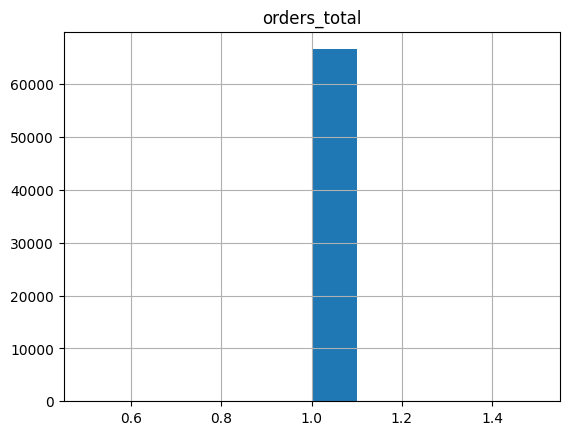

In [44]:
result.hist('orders_total')

## Join item level dataframe into one

In [ ]:
def join_tables_item_level(order_items_df, products_df):
    '''
    Joins order-item & product
    '''
    order_items_df = order_items_df[['id', 
                                     'order_id', 
                                     'user_id', 
                                     'product_id', 
                                     'inventory_item_id',
                                     # 'status', 
                                     'created_at', 
                                     # 'shipped_at', 
                                     # 'delivered_at', 
                                     # 'returned_at',
                                     'sale_price']].rename(columns={'id':'order_item_id'})

    order_items_df['created_at'] = pd.to_datetime(order_items_df['created_at'],
                                                       format='mixed').dt.tz_localize(None)
    products_df = products_df[['id', 
                               'cost', 
                               'category', 
                               'name',
                               'brand',
                               'retail_price', 
                               # 'department',
                               # 'sku',
                               'distribution_center_id']]

    
    df_joined = order_items_df.merge(products_df, left_on='product_id', right_on='id', how='left')
    df_joined = df_joined.drop(columns=['id']) # duplicate product id    

    return df_joined

## Check to see if we can group brand

In [ ]:
item_level_df = join_tables_item_level(order_items_df, products_df)

In [ ]:
# Checking top brands 

data_agg = item_level_df[['order_id','brand']].groupby(by='brand').count().sort_values(by='order_id', ascending=False).reset_index()

# Calculate cumulative sum of 'order_id' for each brand
data_agg['cumulative_sum'] = data_agg['order_id'].cumsum()

# Calculate percentage of total 'order_id'
total_orders = data_agg['order_id'].sum()
data_agg['percentage'] = (data_agg['cumulative_sum'] / total_orders) * 100

# Plot using Seaborn
plt.figure(figsize=(8, 4))
sns.lineplot(x=data_agg.index, y=data_agg['percentage'])
plt.xlabel('Brand')
plt.ylabel('% of Total Order_id')
plt.title('Cumulative % of Total Order_id by Brand')
# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Checking top brands 

data_agg = item_level_df[['order_id','category']].groupby(by='category').count().sort_values(by='order_id', ascending=False).reset_index()

# Calculate cumulative sum of 'order_id' for each brand
data_agg['cumulative_sum'] = data_agg['order_id'].cumsum()

# Calculate percentage of total 'order_id'
total_orders = data_agg['order_id'].sum()
data_agg['percentage'] = (data_agg['cumulative_sum'] / total_orders) * 100

# Plot using Seaborn
plt.figure(figsize=(8, 4))
sns.lineplot(x=data_agg.index, y=data_agg['percentage'])
plt.xlabel('Category')
plt.ylabel('% of Total Order_id')
plt.title('Cumulative % of Total Order_id by Category')
# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


## - Joined Dataframe Aggregation
### -- Calculates preffered brand and category

In [ ]:
def calc_product_features(item_level_df, split_date):
    '''
    takes item-level dataframe and calculate features to user level.
    '''

    # filter data only for last 2 years -> changed to whole period
    # min_date = split_date - pd.DateOffset(days=days_history)
    # item_level_df = item_level_df[(item_level_df['created_at'] <= split_date) & (item_level_df['created_at'] > min_date)].copy()
    item_level_df = item_level_df[(item_level_df['created_at'] <= split_date)].copy().reset_index()
    
    # # Calculate the first orders
    # item_level_df['order_rank'] = item_level_df.groupby('user_id')['created_at'].rank().astype(int) # calculating the order of orders
    # item_level_df['order_rank_desc'] = item_level_df.groupby('user_id')['created_at'].rank(method='max').astype(int) # calculating the order of orders

    base = item_level_df[['user_id','order_item_id']].groupby('user_id').count().fillna(0).rename(columns={'order_item_id':'num_order_item'}).reset_index()
    
    # # taking value for the very first order
    # intial_values = item_level_df[item_level_df['order_rank']==1][['user_id','category','brand']].rename(columns={'category':'categ_initial',
    #                                                                                                               'brand':'brand_initial'})
    # base = base.merge(intial_values, on='user_id', how='left')

    # # taking value for the very last order
    # last_values = item_level_df[item_level_df['order_rank_desc']==1][['user_id','category','brand']].rename(columns={'category':'categ_last',
    #                                                                                                               'brand':'brand_last'})
    # base = base.merge(last_values, on='user_id', how='left')

    # item_level_df = item_level_df.rename(columns={'created_at':'order_item_created_at'})

    # Most frequent category
    count_cat = item_level_df.groupby(['user_id', 'category']).size().reset_index(name='count')
    # Find the index of the row with the maximum count for each user
    max_count_index = count_cat.groupby('user_id')['count'].idxmax()
    # Extract the rows corresponding to the maximum counts
    preferred_categories = count_cat.loc[max_count_index]
    # remove duplicates
    pref_cat_no_duplicates = preferred_categories.drop_duplicates(subset=['user_id']).rename(columns={'category':'category_preffered'})

    base = base.merge(pref_cat_no_duplicates[['user_id','category_preffered']],on='user_id',how='left')            
    
    return base

## User dataset

In [ ]:
def select_user_columns(users_df, split_date):

    df = users_df[['id','age','country','created_at','traffic_source']].rename(columns={'id':'user_id','created_at':'user_created_at'})
    # Filter users only for last 2 years from split date
    # min_date = split_date - pd.DateOffset(days=365*5)

    def assign_age_group(age):
        if age <= 15:
            return '00_15'
        elif age <= 25:
            return '16_25'
        elif age <= 35:
            return '26_35'
        elif age <= 45:
            return '36_45'
        elif age <= 55:
            return '46_55'
        else:
            return '56_99'

    df['age_group'] = df['age'].apply(assign_age_group)    
    df['user_created_at'] = pd.to_datetime(df['user_created_at'], format='mixed').dt.tz_localize(None)
    df = df[(df['user_created_at'] <= split_date)]
    
    return df

## Y Actual

In [ ]:
def create_y_actual(order_items_df, split_date, days_predict):
    df = order_items_df[['id','user_id','created_at','sale_price']].copy().rename(columns={'id':'order_item_id'})
    df['order_created_at'] = pd.to_datetime(df['created_at'], format='mixed').dt.tz_localize(None)

    # select next 90 days of revenue from split_date
    max_date = split_date + pd.DateOffset(days=days_predict)
    df = df[(df['order_created_at'] <= max_date) & (df['order_created_at'] > split_date)]
    
    df_agg = df[['user_id','sale_price']].groupby('user_id').sum().fillna(0).rename(columns={'sale_price':'future_clv'})

    return df_agg

## Event Dataset

In [ ]:
def event_dataset(events_df, split_date):
    '''
    Returns most used browser per user_id
    '''
    
    events_df = events_df[events_df['user_id'].notna()].copy()
    events_df['created_at'] = pd.to_datetime(events_df['created_at'], format='mixed').dt.tz_localize(None)
    events_df = events_df[events_df['created_at'] < split_date]
    
    # Preffered browser
    count_browser = events_df.groupby(['user_id', 'browser']).size().reset_index(name='count')
    max_count_index = count_browser.groupby('user_id')['count'].idxmax()
    preferred_browser = count_browser.loc[max_count_index]
    pref_brsr_no_duplicates = preferred_browser.drop_duplicates(subset=['user_id']).rename(columns={'browser':'browser_preffered'})
    base = pref_brsr_no_duplicates[['user_id','browser_preffered']]


    # ----------------------------- RFM with events -----------------------------

    cart_events = events_df[events_df.event_type == 'cart'].copy()
    cart_events['days_to_split_date'] = (split_date - cart_events['created_at']).dt.days
    
    # Base dataset : user level
    total_carts = cart_events[['user_id','session_id']].groupby('user_id').nunique().rename(columns={'session_id': 'carts_total'})
    base = base.merge(total_carts, on='user_id', how='left')

    # Calculate first event, latest event
    first_cart = cart_events[['user_id','created_at']].groupby('user_id').min().rename(columns={'created_at': 'min_cart_at'})
    base = base.merge(first_cart, on='user_id')
    latest_purchase = cart_events[['user_id','created_at']].groupby('user_id').max().rename(columns={'created_at': 'max_cart_at'})
    base = base.merge(latest_purchase, on='user_id')

    # Days from first/last order (Recency, customer T)
    base['days_from_first_cart'] =  (split_date - base['min_cart_at']).dt.days # This is customer T
    base['days_from_last_cart'] =  (split_date - base['max_cart_at']).dt.days # This is recency
    base['cart_frequency'] =  base['days_from_first_cart']/base['carts_total'] # how many orders did he/she make since first purchase
    
    min_date = cart_events['created_at'].min()
    time_total = (split_date - min_date).days
    time_section = int(time_total/5)
    
    # Count of orders per period
    df_5 = cart_events[cart_events.days_to_split_date < time_section]
    df_4 = cart_events[(cart_events.days_to_split_date >= time_section) & (cart_events.days_to_split_date < time_section*2)]
    df_3 = cart_events[(cart_events.days_to_split_date >= time_section*2) & (cart_events.days_to_split_date < time_section*3)]
    df_2 = cart_events[(cart_events.days_to_split_date >= time_section*3) & (cart_events.days_to_split_date < time_section*4)]
    df_1 = cart_events[(cart_events.days_to_split_date >= time_section*4) & (cart_events.days_to_split_date < time_total)]

    # orders per different timeframe
    f_5 = df_5[['user_id','session_id']].groupby(by='user_id').nunique().fillna(0).rename(columns={'session_id': 'carts_5'})
    f_4 = df_4[['user_id','session_id']].groupby(by='user_id').nunique().fillna(0).rename(columns={'session_id': 'carts_4'})
    f_3 = df_3[['user_id','session_id']].groupby(by='user_id').nunique().fillna(0).rename(columns={'session_id': 'carts_3'})
    f_2 = df_2[['user_id','session_id']].groupby(by='user_id').nunique().fillna(0).rename(columns={'session_id': 'carts_2'})
    f_1 = df_1[['user_id','session_id']].groupby(by='user_id').nunique().fillna(0).rename(columns={'session_id': 'carts_1'})

    # Frequency Joined to base dataset
    base = base.merge(f_5,on='user_id',how='left')
    base = base.merge(f_4,on='user_id',how='left')
    base = base.merge(f_3,on='user_id',how='left')
    base = base.merge(f_2,on='user_id',how='left')
    base = base.merge(f_1,on='user_id',how='left')

    # Fill NA with 0 for selected columns
    selected_columns = [
        'carts_total',
        'carts_5',
        'carts_4',
        'carts_3',
        'carts_2',
        'carts_1']

    base[selected_columns] = base[selected_columns].fillna(0)
    
    return base

In [ ]:
event_temp = event_dataset(events_df, temp_date)

In [ ]:
event_temp['carts_total'].hist()

In [ ]:
# Setting test dataset

test_date = dt.datetime(2024,1,1)
item_level_df = join_tables_item_level(order_items_df, products_df)

In [ ]:
df_user = select_user_columns(users_df, test_date)
df_order = order_features(orders_df, order_items_df, test_date)
df_item = calc_product_features(item_level_df, test_date)
df_event = event_dataset(events_df, test_date)
df_y_actual = create_y_actual(order_items_df, test_date, 180)

## Checking if there are any duplicates

In [ ]:
df_user.user_id.count(), df_user.user_id.nunique()

In [ ]:
df_order.user_id.count(), df_order.user_id.nunique()

In [ ]:
df_item.user_id.count(), df_item.user_id.nunique()

In [ ]:
df_event.user_id.count(), df_event.user_id.nunique()

In [ ]:
df_y_actual.reset_index().user_id.count() , df_y_actual.reset_index().user_id.nunique()

## Join all the prepped datasets

In [ ]:
def prep_input_dataset(df_user, df_order, df_item, df_event, df_y_actual):
    '''
    joins all preprocessed user-level-df
    '''
    
    final_df = df_user.merge(df_order, on='user_id', how='left')
    final_df = final_df.merge(df_item, on='user_id', how='left')
    final_df = final_df.merge(df_event, on='user_id', how='left')
    final_df = final_df.merge(df_y_actual, on='user_id', how='left')

    final_df = final_df[final_df['orders_total']>0].copy()

    final_df = final_df.reset_index()

    return final_df


In [ ]:
input_dataset = prep_input_dataset(df_user, df_order, df_item, df_event, df_y_actual)
input_dataset.columns

## Preprocessor Pipelines

In [ ]:
# List of columns to drop
columns_to_drop = ['user_id','index','avg_delivery_days','future_clv']

X = input_dataset.drop(columns=columns_to_drop).copy()
y = input_dataset['future_clv'].fillna(0).copy()

In [ ]:
X.columns

In [ ]:
y.hist()

In [ ]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler()
)

preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)


preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_categorical_baseline, make_column_selector(dtype_include=["object"])),
    remainder="drop"
)

preproc_baseline

In [ ]:
X.columns

## Model Selection

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
pipe_tree = make_pipeline(preproc_baseline, DecisionTreeRegressor())
pipe_tree

In [ ]:
score_baseline = cross_val_score(pipe_tree, X_train, y_train, cv=5, scoring='r2').mean()

score_baseline

In [ ]:
pipe_xgb = make_pipeline(preproc_baseline, XGBRegressor())
pipe_xgb

In [ ]:
score_baseline_xgb = cross_val_score(pipe_xgb, X_train, y_train, cv=5, scoring='r2').mean()

score_baseline_xgb

In [ ]:
pipe_randomforest = make_pipeline(preproc_baseline, RandomForestRegressor())
pipe_randomforest

In [ ]:
# # takes very long time!!!!!!!!! result = 0.8623132669939197
# score_randomforest = cross_val_score(pipe_randomforest, X_train, y_train['future_clv'], cv=5, scoring='r2').mean()
# score_randomforest

### Other models

In [ ]:
# Ridge with normal target
model = Ridge()
pipe_ridge = make_pipeline(preproc_baseline, model)
cross_val_score(pipe_ridge, X, y, cv=5, scoring='r2').mean()

In [ ]:
# Ridge with normal target
model = KNeighborsRegressor()
pipe_knn = make_pipeline(preproc_baseline, model)
cross_val_score(pipe_knn, X, y, cv=5, scoring='r2').mean()

In [ ]:
# Taking too long - giving up
# model = SVR(kernel='rbf', C = 10)
# pipe_svm_rbf = make_pipeline(preproc_baseline, model)
# cross_val_score(pipe_svm_rbf, X, y, cv=5, scoring='r2').mean()

In [ ]:
# # ADA Boost

# model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=None))
# pipe_ada_boost = make_pipeline(preproc_baseline, model)
# score = cross_val_score(pipe_ada_boost, X, y, cv=5, scoring='r2')

## Train Fit, Predict, Evaluate

In [ ]:
pipe_randomforest.fit(X_train, y_train)

In [ ]:
y_randomforest = pipe_randomforest.predict(X_test)
r2 = r2_score(y_test, y_randomforest)
print("R-squared:", r2)

In [ ]:
y_test_flatten= y_test.values.flatten()
sns.scatterplot(x=y_test_flatten, y=y_randomforest)

# Add labels and title
plt.xlabel('y (Actual)')
plt.ylabel('y_pred (Predicted)')
plt.title('Actual vs. Predicted')

# Show plot
plt.grid(True)
plt.show()

In [ ]:
# Residual Plot

# Calculate residuals
residuals = y_test_flatten - y_randomforest

# Create residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_randomforest, residuals, color='blue')

# Add a horizontal line at y=0
plt.axhline(y=0, color='red', linestyle='--')

# Add labels and title
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Show plot
plt.grid(True)
plt.show()

## Try Resample

## Trying DeepLearning

In [ ]:
''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Normalization
from tensorflow.keras.metrics import Recall, Precision


In [ ]:
y_binary = y.apply(lambda x: 1 if x > 0 else 0)

In [ ]:
X_t = preproc_baseline.fit_transform(X)

In [ ]:
# Train test split before any resampling to keep real test set
X_train, X_test, y_train, y_test = train_test_split(X_t, y_binary, test_size = 0.3)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3)

In [ ]:
# How many "fraud" samples do I have in each split?
print(np.sum(y_train[y_train == 1]))
print(np.sum(y_val[y_val == 1]))
print(np.sum(y_test[y_test == 1]))

print("-"*100)

print(f"There are {pd.Series(y_train).value_counts()[1]} purchased users in the train set")
print(f"There are {pd.Series(y_val).value_counts()[1]} purchased users in the val set")
print(f"There are {pd.Series(y_test).value_counts()[1]} purchased users in the test set")

In [ ]:
# Sampling strategies
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.33)

In [ ]:
# Pipelining the two strategies
steps =  [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
pipeline

In [ ]:
# Rebalance the dataset
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print(f"X_train_resampled.shape = {X_train_resampled.shape}")
print(f"y_train_resampled.shape = {y_train_resampled.shape}")

In [ ]:
# Reshuffle the resampled data just to be sure
stacked_resampled_data = np.hstack([X_train_resampled, y_train_resampled.values.reshape(-1,1)])
np.random.shuffle(stacked_resampled_data)

X_train_resampled = stacked_resampled_data[:,:86]
y_train_resampled = stacked_resampled_data[:,-1]

In [ ]:
# plotting
# warnings.filterwarnings('ignore')
fig, ax = plt.subplots(1, 2, figsize=(18,4))

''' Before rebalancing classes'''

sns.histplot(y_train, ax=ax[0], color='b')
ax[0].set_title('Y_train before balancing', fontsize=14)

''' After rebalancing classes'''

sns.histplot(y_train_resampled, ax=ax[1], color='b')
ax[1].set_title('Y_train after balancing', fontsize=14);

In [ ]:
print(X_train_resampled.shape)
print(X_val.shape)

## Neural Network Iteration

In [ ]:
metrics = [
    keras.metrics.Recall(name='recall'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

In [ ]:
def init_model():
    input_shape = X_train_resampled.shape[1:]
    normalizer = Normalization()
    normalizer.adapt(X_train_resampled)
    
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    # Model compilation
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    return model

## Regularized model

In [ ]:
model = init_model()

es = EarlyStopping(
    patience=10,
    monitor='val_recall', # We really want to detect fraudulent transactions!
    restore_best_weights=True)

history = model.fit(X_train_resampled, y_train_resampled,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=4,
                    callbacks=[es], shuffle=True)

In [ ]:
def plot_loss_precision_recall_curve(history):
    
    fig, ax =plt.subplots(1,3,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- RECALL

    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model recall', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    
    # --- PRECISION
    
    
    ax[2].plot(history.history['precision'])
    ax[2].plot(history.history['val_precision'])
    ax[2].set_title('Model precision', fontsize = 18)
    ax[2].set_xlabel('Epoch', fontsize = 14)
    ax[2].set_ylabel('Precision', fontsize = 14)
    ax[2].legend(['Train', 'Val'], loc='lower right')  
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)    
    
    plt.show()

In [ ]:
plot_loss_precision_recall_curve(history)

## Score it

In [ ]:
model.evaluate(X_test, y_test, verbose=0, return_dict=True)

In [ ]:
y_pred_proba = model.predict(X_test)

In [ ]:
threshold = 0.50 # 50% 

y_pred_binary = np.where(y_pred_proba > threshold, 1, 0 )

## Confusion Matrix

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_binary)
cm

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_binary))

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.plot(recall, precision, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
plot_prc("Test", y_test, y_pred_proba, linestyle='--')
plt.legend(loc='lower right')